In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu)

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]
        
    Bt = transpose(B)
    
    if(False): # This does atomics - very slow
        C = tf.zeros([N, K])
        i, j, k = tf.indices([N, K, M])
        tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])
    else: # This does a loop - much faster
        C = tf.buffer([N, K])
        i, j = C.indices
        s = tf.zeros([N, K], tf.float32)
        def loop_body(k):
            s.set(s + A[i, k] * Bt[j, k])
        tf.loop(loop_body, 0, M, 1)
        C[i, j] = s
        
    return [C]

mmul = tf.compile(matmul)

TensorFrost module loaded!
matmul:
  Kernel count: 2
  Intermediate buffers: 1
  Lines of generated code: 347



In [2]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[ 9.371032   9.842482   8.323223  ...  9.469796   9.808056   8.405521 ]
 [ 9.741856   9.836499   8.614546  ... 10.018335   9.134387   8.176449 ]
 [ 8.8218     9.012598   7.1600237 ...  9.533366   7.708182   7.7863197]
 ...
 [ 9.294437  10.686696   7.746114  ...  9.581823   8.4665     8.071134 ]
 [ 9.2066345  8.672739   7.860156  ...  9.836047   8.014751   7.4120674]
 [ 8.36515    9.809425   8.199765  ...  9.113402   9.137913   8.307453 ]]
[[ 9.371031   9.8424835  8.323223  ...  9.469797   9.808058   8.405521 ]
 [ 9.741856   9.836498   8.614546  ... 10.018335   9.134388   8.17645  ]
 [ 8.821799   9.012596   7.1600237 ...  9.533365   7.7081814  7.7863197]
 ...
 [ 9.294436  10.686697   7.7461143 ...  9.581823   8.466499   8.071133 ]
 [ 9.206635   8.672739   7.8601565 ...  9.836047   8.014753   7.4120674]
 [ 8.365151   9.809424   8.199764  ...  9.113403   9.137913   8.307453 ]]
Error: 6.768094e-08


In [3]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.0011307619266087304
TensorFrost:  0.015396826450641339
TF/NP:  13.616329032953898


In [4]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

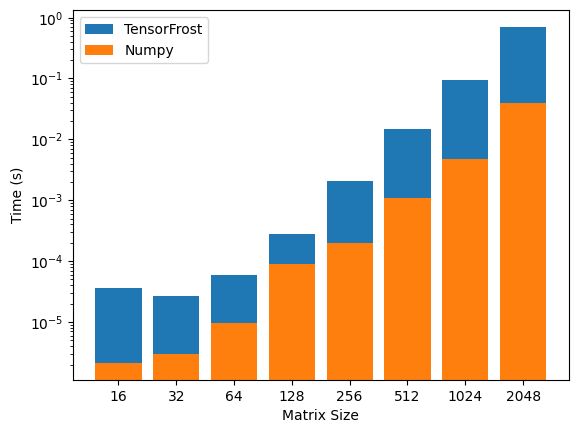

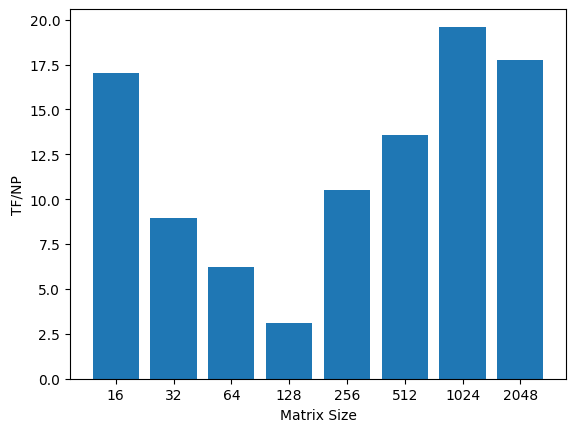

[3.6305794237331995e-05, 2.687489742181639e-05, 5.9086320869867456e-05, 0.0002808198249166127, 0.002101844711623602, 0.014773200539981617, 0.0931385647166859, 0.7025240659713745]
[2.1300125840912647e-06, 2.9939209681199704e-06, 9.520040642112904e-06, 9.08080415730037e-05, 0.0001994605269728665, 0.0010865627748570146, 0.004749249508030607, 0.0395277738571167]


In [5]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)